 __Project - Wine classification__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Categorical feature EDA](#Categorical-feature-EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Engineering](#Engineering)
    1. [Encoding](#Encoding)
    1. [Transformation](#Transformation)
        1. [Polynomial features](#Polynomial-features)
        1. [Skew](#Skew)
        1. [Scale](#Scale)
    1. [Outliers](#Outliers)
1. [Feature importance](#Feature-importance)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Validation set evaluation - standard models](#Validation-set-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Validation set evaluation - stacked models](#Validation-set-evaluation-stacked-models)


# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
from functools import reduce
import time; rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500); pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble
import sklearn.impute as impute
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing

import eif
import shap
shap.initjs()
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PlayWithPandas,
        UnprocessedColumnAdder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
        dataRefresh,
        ConvertToCategory,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

Using TensorFlow backend.


## Data

<a id = 'Data'></a>

In [2]:
# load and inspect data
data = pd.read_csv("../../data/wine.data", header=None)

data.columns = [
    "Class label",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline",
]

print("Training data dimensions: {}".format(data.shape))

Training data dimensions: (178, 14)


In [3]:
# display info and first 5 rows
data.info()
display(data[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class label                     178 non-null int64
Alcohol                         178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.230000,1.710000,2.430000,15.600000,127,2.800000,3.060000,0.280000,2.290000,5.640000,1.040000,3.920000,1065
1,1,13.200000,1.780000,2.140000,11.200000,100,2.650000,2.760000,0.260000,1.280000,4.380000,1.050000,3.400000,1050
2,1,13.160000,2.360000,2.670000,18.600000,101,2.800000,3.240000,0.300000,2.810000,5.680000,1.030000,3.170000,1185
3,1,14.370000,1.950000,2.500000,16.800000,113,3.850000,3.490000,0.240000,2.180000,7.800000,0.860000,3.450000,1480
4,1,13.240000,2.590000,2.870000,21.000000,118,2.800000,2.690000,0.390000,1.820000,4.320000,1.040000,2.930000,735


In [4]:
# review counts of different column types
data.dtypes.value_counts()

float64    11
int64       3
dtype: int64

In [5]:
# split dataset into train and validation datasets
dfTrain, dfValid = mlm.trainTestCompile(data=data, targetCol='Class label')

In [6]:
# Load training data into mlmachine
train = mlm.Machine(
    data=dfTrain,
    target="Class label",
    targetType="categorical",
)
print(train.data.shape)

******************
Categorical label encoding

1 --> 0
2 --> 1
3 --> 2
(142, 13)


In [7]:
# Load training data into mlmachine
valid = mlm.Machine(
    data=dfValid,
    target="Class label",
    targetType="categorical",
)
print(valid.data.shape)

******************
Categorical label encoding

1 --> 0
2 --> 1
3 --> 2
(36, 13)


# EDA

<a id = 'EDA'></a>

## Categorical feature EDA

<a id = 'Categorical-feature-EDA'></a>

##### Univariate & feature vs. target

In [8]:
# categorical features
for feature in train.featureByDtype["categorical"]:
    train.edaCatTargetCatFeat(feature=feature)

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

##### Univariate & feature vs. target

Descriptive stats,bivariate stats
,Alcohol
count,142.000000
mean,12.960493
std,0.814532
min,11.030000
25%,12.330000
50%,13.040000
75%,13.635000
max,14.750000
skew,-0.094670


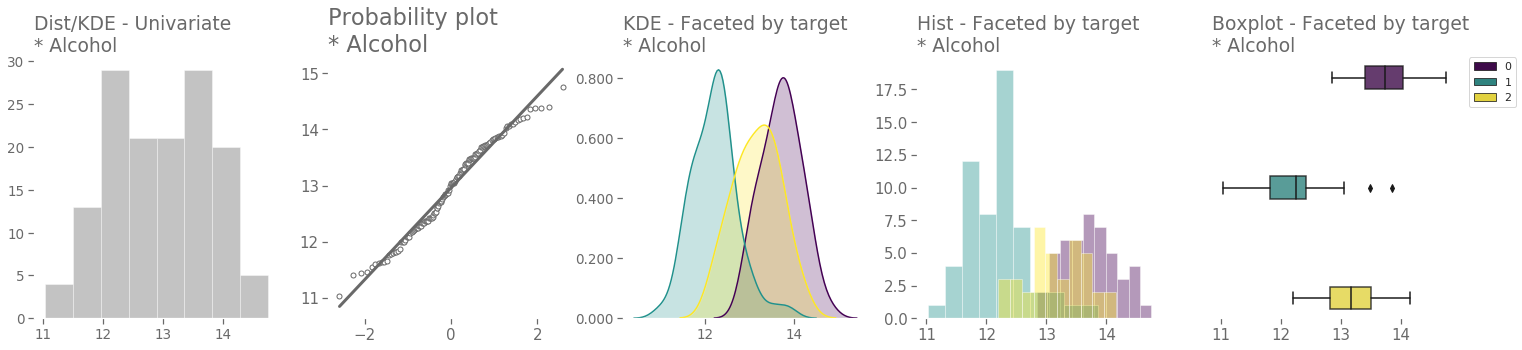

Descriptive stats,bivariate stats
,Malic acid
count,142.000000
mean,2.397465
std,1.127104
min,0.740000
25%,1.610000
50%,1.885000
75%,3.225000
max,5.650000
skew,0.947320


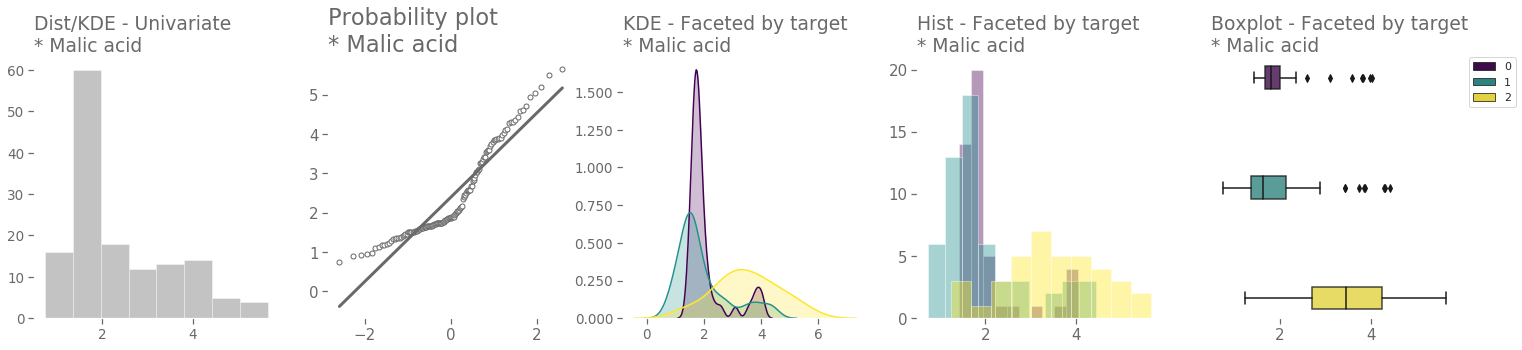

Descriptive stats,bivariate stats
,Ash
count,142.000000
mean,2.381620
std,0.281109
min,1.360000
25%,2.230000
50%,2.375000
75%,2.597500
max,3.230000
skew,-0.174960


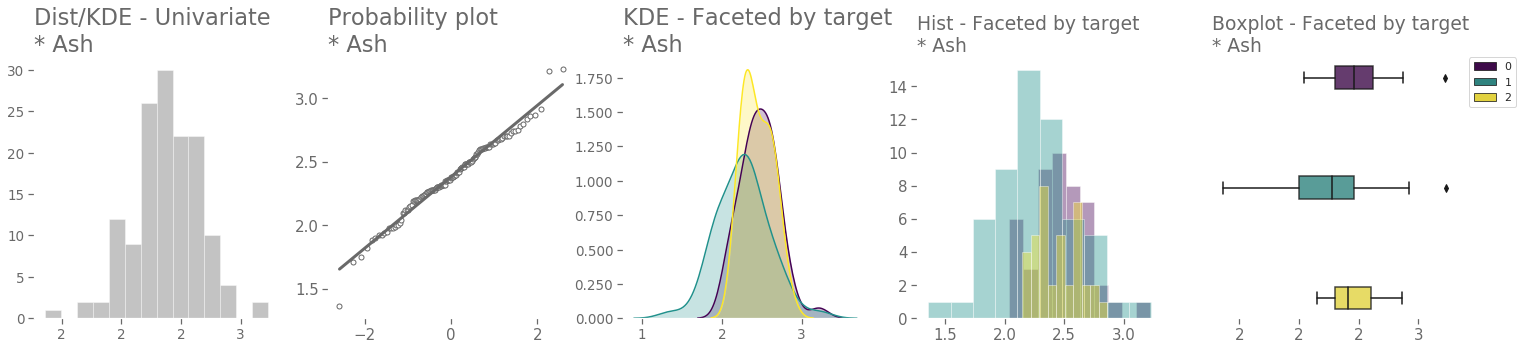

Descriptive stats,bivariate stats
,Alcalinity of ash
count,142.000000
mean,19.676056
std,3.400541
min,10.600000
25%,17.250000
50%,19.500000
75%,21.575000
max,30.000000
skew,0.218650


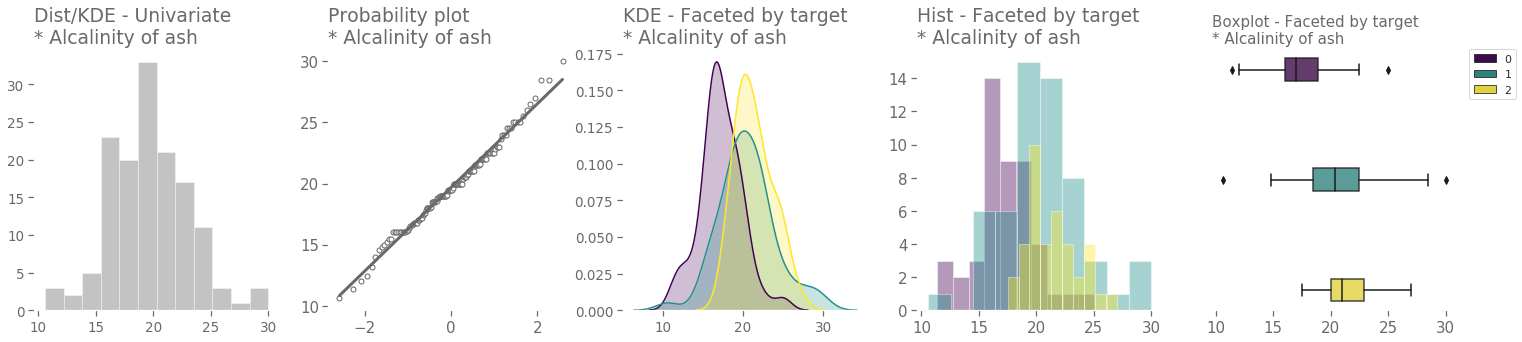

Descriptive stats,bivariate stats
,Magnesium
count,142.000000
mean,100.359155
std,14.924083
min,70.000000
25%,88.000000
50%,98.000000
75%,108.000000
max,162.000000
skew,1.077310


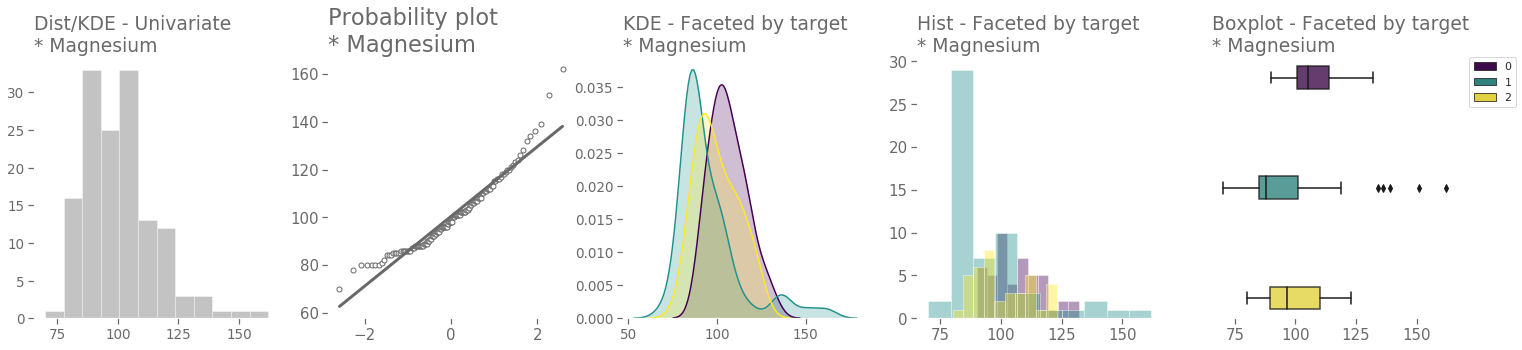

Descriptive stats,bivariate stats
,Total phenols
count,142.000000
mean,2.272465
std,0.625713
min,0.980000
25%,1.705000
50%,2.270000
75%,2.787500
max,3.880000
skew,0.198520


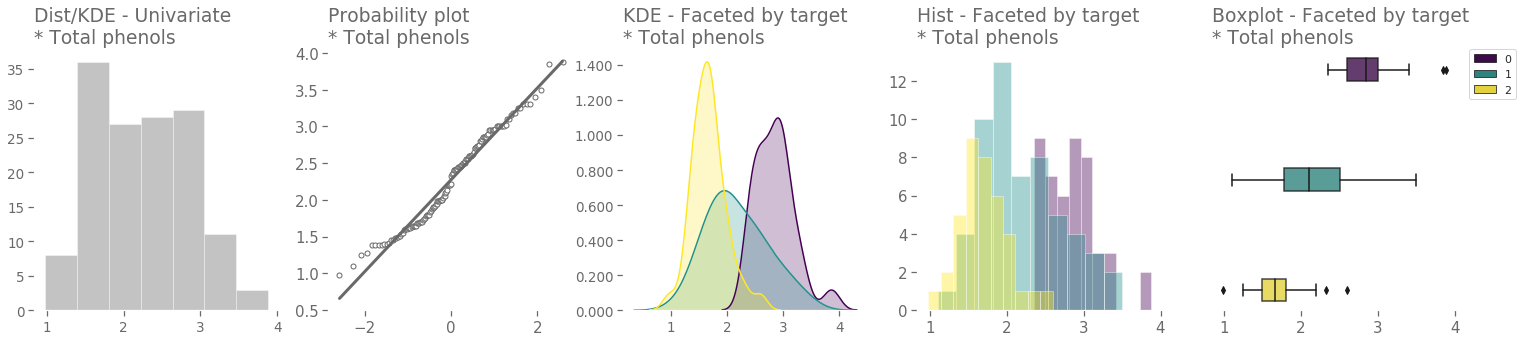

Descriptive stats,bivariate stats
,Flavanoids
count,142.000000
mean,2.007958
std,1.012108
min,0.340000
25%,1.125000
50%,2.035000
75%,2.842500
max,5.080000
skew,0.109660


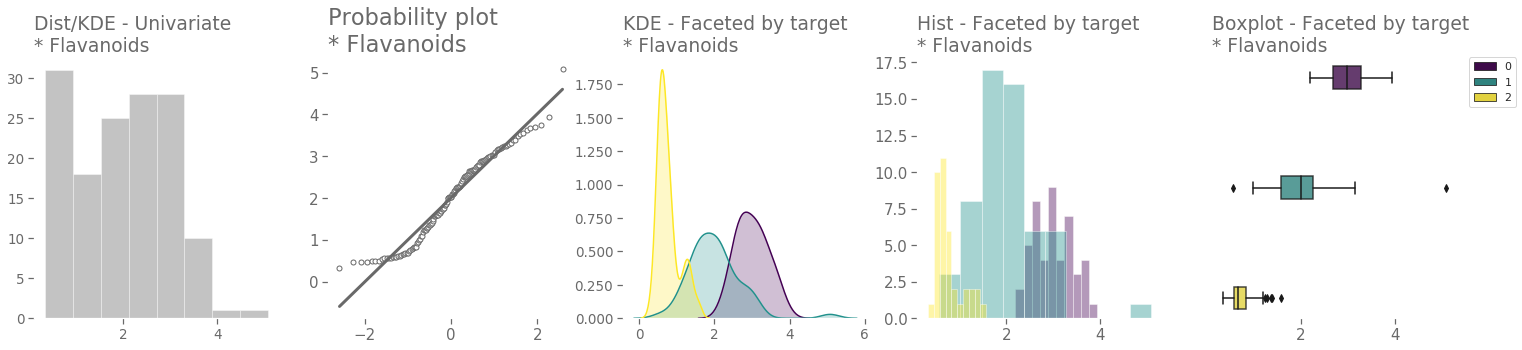

Descriptive stats,bivariate stats
,Nonflavanoid phenols
count,142.000000
mean,0.368592
std,0.128458
min,0.140000
25%,0.270000
50%,0.345000
75%,0.447500
max,0.660000
skew,0.378160


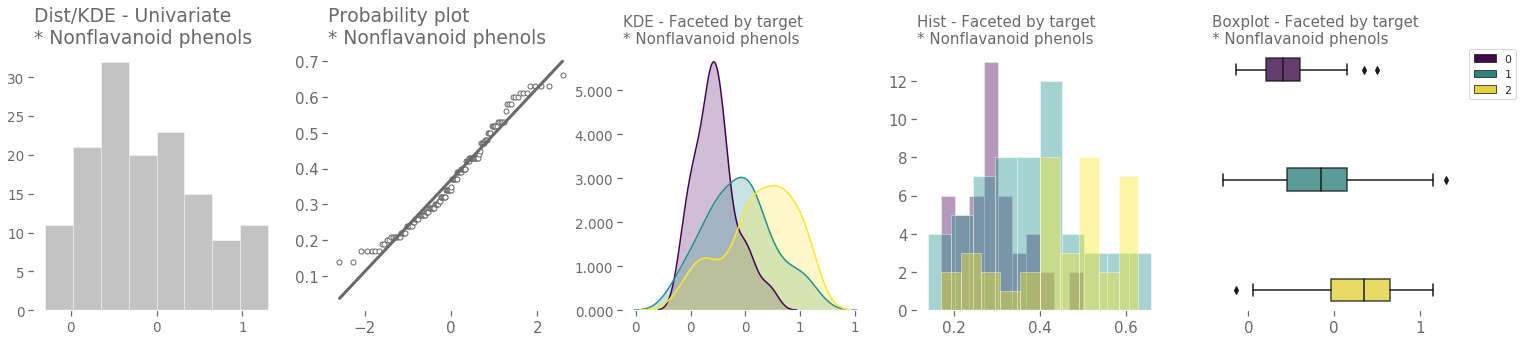

Descriptive stats,bivariate stats
,Proanthocyanins
count,142.000000
mean,1.604648
std,0.569526
min,0.410000
25%,1.250000
50%,1.560000
75%,1.942500
max,3.580000
skew,0.627570


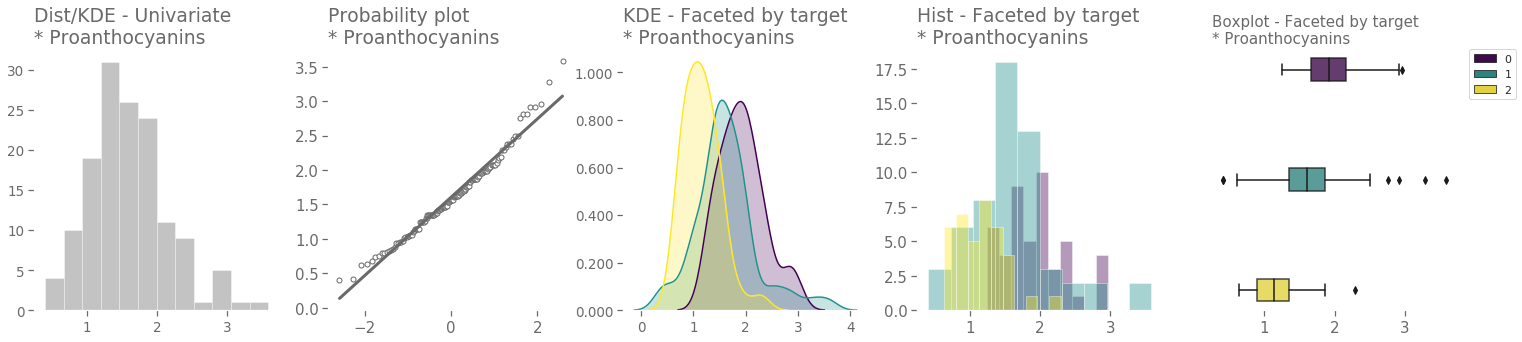

Descriptive stats,bivariate stats
,Color intensity
count,142.000000
mean,5.003310
std,2.291925
min,1.280000
25%,3.122500
50%,4.640000
75%,6.122500
max,11.750000
skew,0.799580


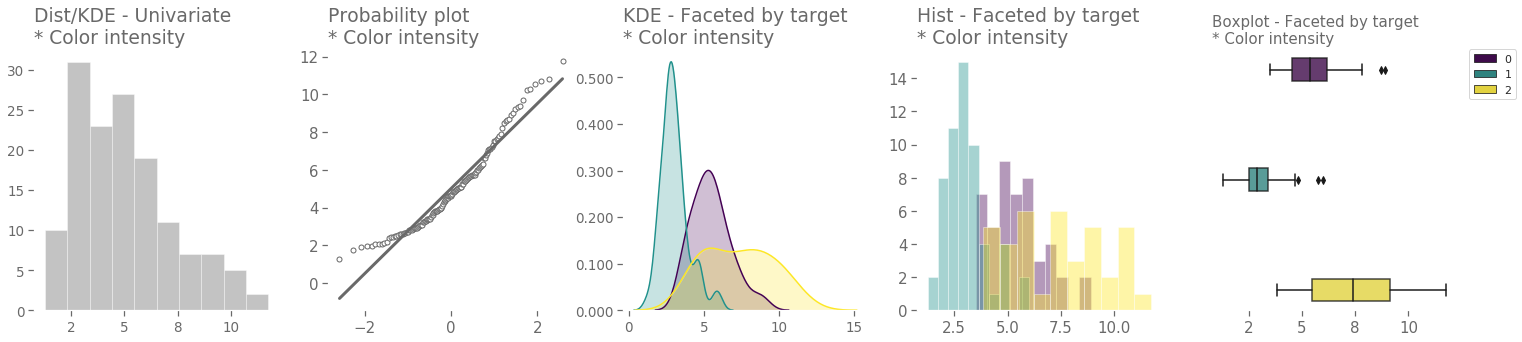

Descriptive stats,bivariate stats
,Hue
count,142.000000
mean,0.958282
std,0.225256
min,0.480000
25%,0.792500
50%,0.960000
75%,1.117500
max,1.710000
skew,0.083970


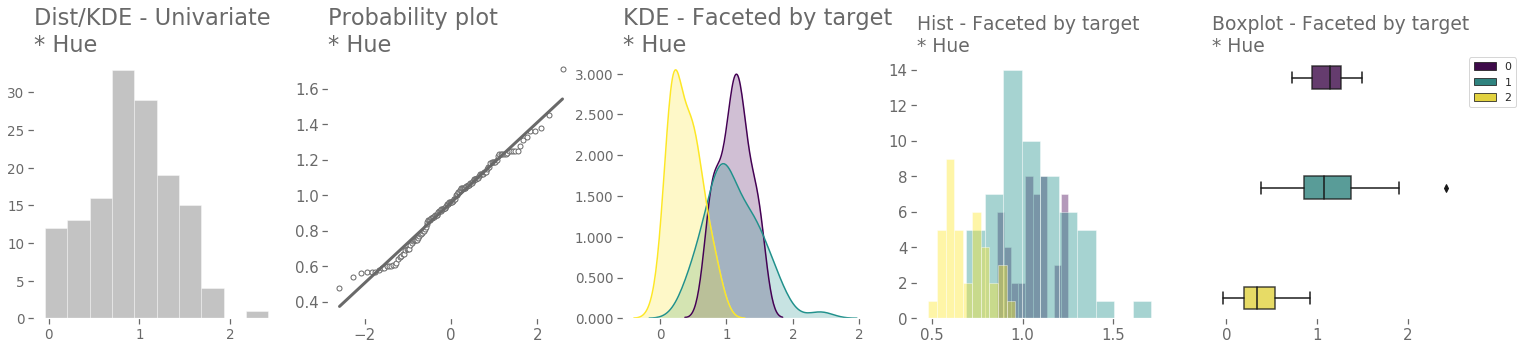

Descriptive stats,bivariate stats
,OD280/OD315 of diluted wines
count,142.000000
mean,2.613451
std,0.718471
min,1.270000
25%,1.940000
50%,2.775000
75%,3.200000
max,4.000000
skew,-0.283980


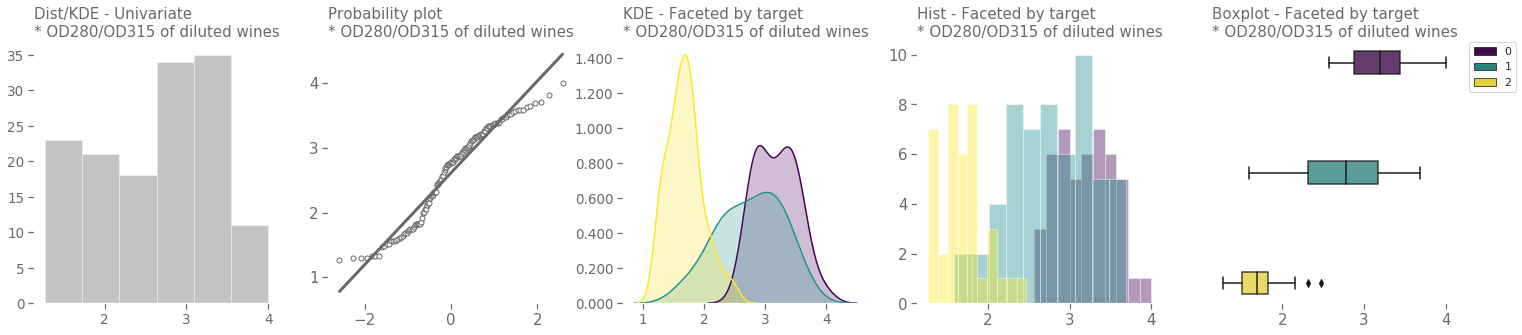

Descriptive stats,bivariate stats
,Proline
count,142.000000
mean,743.422535
std,316.849436
min,278.000000
25%,495.000000
50%,676.500000
75%,973.000000
max,"1,680.000000"
skew,0.781210


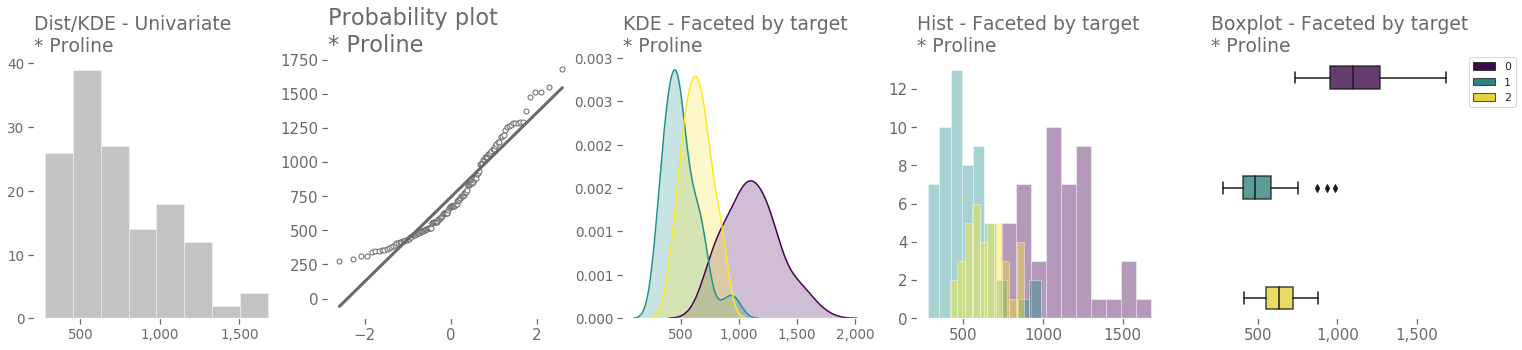

In [9]:
# continuous features
for feature in train.featureByDtype["continuous"]:
    train.edaCatTargetNumFeat(feature=feature)

##### Correlation

###### Correlation (all samples)

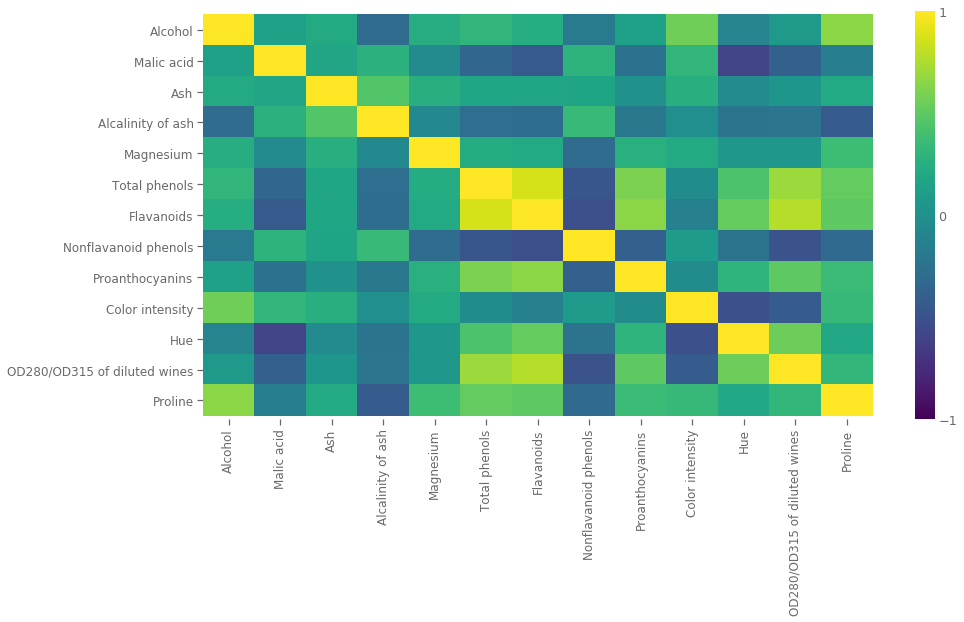

In [10]:
# correlation heat map
p = PrettierPlot()
ax = p.makeCanvas()
p.prettyCorrHeatmap(df=train.data, annot=False, ax=ax)

###### Correlation (top vs. target)

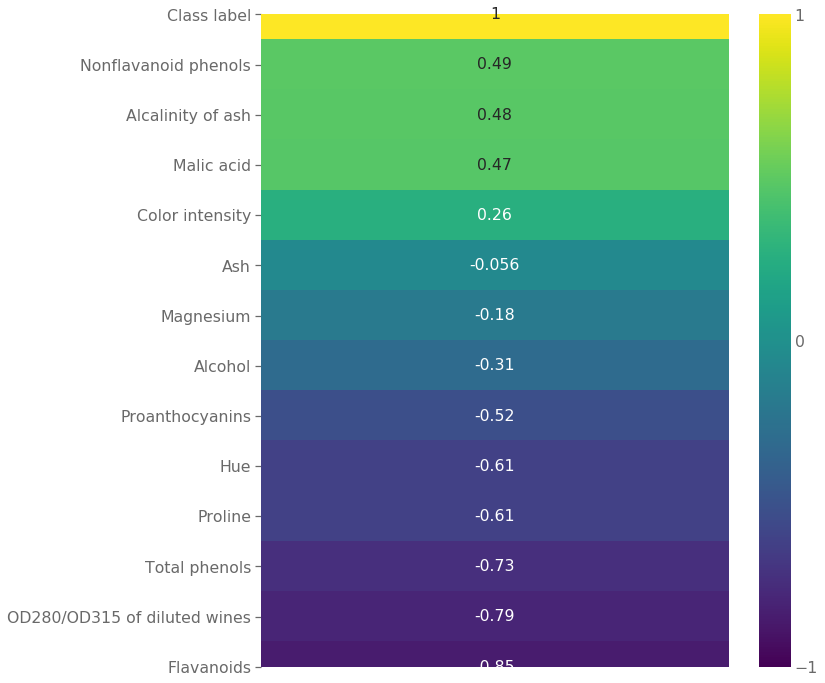

In [11]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plotOrientation='tall')
ax = p.makeCanvas()
p.prettyCorrHeatmapTarget(
    df=train.data, target=train.target, thresh=0.02, annot=True, ax=ax
)

##### Pair plot

In [12]:
# # pair plot
# p = PrettierPlot(chartProp=12)
# p.prettyPairPlot(df=train.data, cols=train.featureByDtype['continuous'], diag_kind="auto")

In [13]:
# # pair plot
# p = PrettierPlot(chartProp=12)
# p.prettyPairPlot(
#     df=train.data.dropna(),
#     diag_kind="kde",
#     target=train.target,
#     cols=train.featureByDtype['continuous'][:10],
#     legendLabels=["Cat1", "Cat2","Cat3"],
#     bbox=(2.0, 0.0),
# )

## Faceting

<a id = 'Faceting'></a>

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [14]:
# null score
pd.Series(train.target).value_counts(normalize=True)

1   0.401408
0   0.330986
2   0.267606
Name: Class label, dtype: float64

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data

No missing data


<a id = 'Missing-data'></a>

##### Training

In [15]:
# evaluate missing data
train.edaMissingSummary()

No nulls


##### Validation

In [16]:
# evaluate missing data
valid.edaMissingSummary()

No nulls


##### Impute

## Engineering

<a id = 'Engineering'></a>

##### Training

In [17]:
# print new columns
for col in train.data.columns:
    if (
        col not in train.featureByDtype["categorical"]
        and col not in train.featureByDtype["continuous"]
    ):
        print(col)

In [18]:
# evaluate additional features
for feature in train.featureByDtype["categorical"]:
    train.edaCatTargetCatFeat(feature=feature)

##### Validation

In [19]:
# print new columns
for col in valid.data.columns:
    if (
        col not in valid.featureByDtype["categorical"]
        and col not in valid.featureByDtype["continuous"]
    ):
        print(col)

## Encoding

No categorical features

<a id = 'Encoding'></a>

## Transformation

<a id = 'Transformation'></a>

### Polynomial features

<a id = 'Polynomial-features'></a>

##### Transformation

In [20]:
X = train.data
Y = valid.data

pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(train.featureByDtype["continuous"]),
        PlayWithPandas(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
    )),
])

X = pipe.fit_transform(train.data)
Y = pipe.transform(valid.data)

In [21]:
# update main train and validation datasets
train.data, train.featureByDtype, valid.data, valid.featureByDtype = dataRefresh(
    transformeredTrainData=X,
    trainData=train.data,
    trainFeatureByDtype=train.featureByDtype,
    transformeredValidationData=Y,
    validationData=valid.data,
    validFeatureByDtype=valid.featureByDtype,
)

### Skew

<a id = 'Skew'></a>

##### Training

In [22]:
# evaluate skew of continuous features - training data
train.skewSummary()

,Skew,PctZero
Alcohol*Ash,-0.333656,0.000000
OD280/OD315*of*diluted*wines,-0.283981,0.000000
OD280/OD315 of diluted wines,-0.283981,0.000000
Hue*OD280/OD315*of*diluted*wines,-0.211335,0.000000
Ash,-0.174961,0.000000
Alcohol,-0.094666,0.000000
Alcohol*OD280/OD315*of*diluted*wines,-0.027740,0.000000
Alcohol^2,0.006293,0.000000
Alcohol*Hue,0.032523,0.000000
OD280/OD315*of*diluted*wines^2,0.058926,0.000000


##### Validation

In [23]:
# evaluate skew of continuous features - validation data
valid.skewSummary()

,Skew,PctZero
Ash,-0.479262,0.000000
Hue*OD280/OD315*of*diluted*wines,-0.461887,0.000000
OD280/OD315 of diluted wines,-0.404379,0.000000
OD280/OD315*of*diluted*wines,-0.404379,0.000000
Total*phenols,-0.361678,0.000000
Total phenols,-0.361678,0.000000
Flavanoids,-0.346279,0.000000
Nonflavanoid*phenols*OD280/OD315*of*diluted*wines,-0.320514,0.000000
Total*phenols*Hue,-0.319868,0.000000
Alcohol*Hue,-0.277417,0.000000


##### Transform

In [24]:
X = train.data
Y = valid.data

pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(train.featureByDtype["continuous"]),
        DualTransformer(),
    )),
])

X = pipe.fit_transform(train.data)
Y = pipe.transform(valid.data)

In [25]:
# update main train and validation datasets
train.data, train.featureByDtype, valid.data, valid.featureByDtype = dataRefresh(
    transformeredTrainData=X,
    trainData=train.data,
    trainFeatureByDtype=train.featureByDtype,
    transformeredValidationData=Y,
    validationData=valid.data,
    validFeatureByDtype=valid.featureByDtype,
)

### Scale

<a id = 'Scale'></a>

##### Transformation

In [26]:
X = train.data
Y = valid.data

pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(train.featureByDtype["continuous"]),
        PlayWithPandas(preprocessing.RobustScaler())
    )),
])

X = pipe.fit_transform(train.data)
Y = pipe.transform(valid.data)

In [27]:
# update main train and validation datasets
train.data, train.featureByDtype, valid.data, valid.featureByDtype = dataRefresh(
    transformeredTrainData=X,
    trainData=train.data,
    trainFeatureByDtype=train.featureByDtype,
    transformeredValidationData=Y,
    validationData=valid.data,
    validFeatureByDtype=valid.featureByDtype,
)

## Outliers


<a id = 'Outliers'></a>

In [28]:
# identify outliers using IQR
trainPipe = pipeline.Pipeline([
    ("outlier",train.OutlierIQR(
                outlierCount=5,
                iqrStep=1.5,
                features=train.featureByDtype["continuous"],
                dropOutliers=False,))
    ])
train.data = trainPipe.transform(train.data)

# capture outliers
iqrOutliers = np.array(sorted(trainPipe.named_steps["outlier"].outliers_))
print(iqrOutliers)

[ 13  14  18  21  25  39  45  50  59  60  73  95 110 115 121 122 124 127
 137 151 155 159 166 173 175]


In [29]:
# identify outliers using Isolation Forest
clf = ensemble.IsolationForest(
    behaviour="new", max_samples=train.data.shape[0], random_state=0, contamination=0.01
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
ifOutliers = np.array(train.data[mask].index)
print(ifOutliers)

[ 59 121]


In [30]:
# identify outliers using extended isolation forest
trainPipe = pipeline.Pipeline([
    ("outlier",train.ExtendedIsoForest(
                cols=train.featureByDtype["continuous"],
                nTrees=100,
                sampleSize=int(np.ceil(train.data.shape[0] * .25)),
                ExtensionLevel=1,
                anomaliesRatio=0.03,
                dropOutliers=False,))
    ])
train.data = trainPipe.transform(train.data)

# capture outliers
eifOutliers = np.array(sorted(trainPipe.named_steps["outlier"].outliers_))
print(eifOutliers)

[ 13  14  18  59 121]


In [31]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqrOutliers, ifOutliers, eifOutliers))
# outliers = reduce(np.intersect1d, (ifOutliers, eifOutliers))
print(outliers)

[ 59 121]


In [32]:
# review outlier identification summary
outlierSummary = train.outlierSummary(iqrOutliers=iqrOutliers,
                             ifOutliers=ifOutliers,
                             eifOutliers=eifOutliers
                            )
outlierSummary[outlierSummary["Count"] >= 3]

,IQR,IF,EIF,Count
121,X,X,X,3
59,X,X,X,3


In [33]:
# remove outlers from predictors and response
outliers = np.array([59,121])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

# Feature importance

<a id = 'Feature-importance'></a>

In [34]:
# generate feature importance summary
estimators = [
    "lightgbm.LGBMClassifier",
    "ensemble.RandomForestClassifier",
    "ensemble.GradientBoostingClassifier",
    "ensemble.ExtraTreesClassifier",
    "ensemble.AdaBoostClassifier",
    "xgboost.XGBClassifier",
]

featureSummary = train.featureSelectorSummary(estimators=estimators)

In [35]:
featureSummary

,average,stdev,low,high,F-value,p-value,Variance,TargetCorrelation,RFE LGBMClassifier,RFE RandomForestClassifier,RFE GradientBoostingClassifier,RFE ExtraTreesClassifier,RFE AdaBoostClassifier,RFE XGBClassifier,FeatureImportance LGBMClassifier,FeatureImportance RandomForestClassifier,FeatureImportance GradientBoostingClassifier,FeatureImportance ExtraTreesClassifier,FeatureImportance AdaBoostClassifier,FeatureImportance XGBClassifier
Flavanoids*Proline,63.125000,73.252873,2.000000,229.000000,17.000000,17.000000,140.000000,33.000000,43.000000,216.000000,11.000000,118.000000,229.000000,24.000000,40.000000,2.000000,10.000000,70.000000,22.000000,18.000000
Flavanoids*OD280/OD315*of*diluted*wines,67.125000,102.861638,1.000000,326.000000,15.000000,15.000000,326.000000,11.000000,8.000000,217.000000,6.000000,136.000000,232.000000,1.000000,3.000000,38.000000,8.000000,54.000000,1.000000,3.000000
Malic*acid*Color*intensity,92.125000,101.270512,9.000000,284.000000,87.000000,87.000000,11.000000,156.000000,58.000000,284.000000,21.000000,276.000000,284.000000,9.000000,60.000000,35.000000,21.000000,53.000000,22.000000,10.000000
Hue*Proline,93.125000,110.387122,6.000000,330.000000,56.000000,56.000000,50.000000,67.000000,23.000000,192.000000,13.000000,20.000000,209.000000,6.000000,23.000000,330.000000,15.000000,89.000000,330.000000,11.000000
Flavanoids*Hue,95.250000,116.580444,3.000000,330.000000,22.000000,22.000000,321.000000,23.000000,3.000000,218.000000,102.000000,141.000000,233.000000,4.000000,6.000000,25.000000,48.000000,330.000000,22.000000,4.000000
Total*phenols*Proline,100.562500,120.867403,2.000000,330.000000,29.000000,29.000000,70.000000,80.000000,20.000000,230.000000,19.000000,196.000000,240.000000,2.000000,12.000000,330.000000,18.000000,2.000000,330.000000,2.000000
Flavanoids*OD280/OD315*of*diluted*wines_bc,103.375000,130.944199,2.000000,330.000000,3.000000,3.000000,325.000000,3.000000,193.000000,2.000000,10.000000,169.000000,3.000000,185.000000,330.000000,26.000000,3.000000,62.000000,7.000000,330.000000
Alcalinity*of*ash*Color*intensity,114.187500,108.934977,3.000000,330.000000,115.000000,115.000000,9.000000,188.000000,15.000000,255.000000,123.000000,243.000000,262.000000,19.000000,18.000000,330.000000,67.000000,48.000000,3.000000,17.000000
Alcohol*Proline_bc,117.937500,117.988965,4.000000,330.000000,33.000000,33.000000,195.000000,155.000000,127.000000,10.000000,32.000000,4.000000,67.000000,101.000000,330.000000,11.000000,60.000000,69.000000,330.000000,330.000000
Ash*Color*intensity,118.750000,116.295314,6.000000,330.000000,108.000000,108.000000,72.000000,257.000000,12.000000,271.000000,43.000000,258.000000,273.000000,12.000000,6.000000,19.000000,80.000000,37.000000,330.000000,14.000000


In [ ]:
# calculate cross-validation performance
estimators = [
    "svm.SVC",
    "lightgbm.LGBMClassifier",
    "linear_model.LogisticRegression",
    "xgboost.XGBClassifier",
    "ensemble.RandomForestClassifier",
    "ensemble.GradientBoostingClassifier",
    "ensemble.AdaBoostClassifier",
    "ensemble.ExtraTreesClassifier",
    "neighbors.KNeighborsClassifier",
]

cvSummary = train.featureSelectorCrossVal(
    estimators=estimators,
    featureSummary=featureSummary,
    metrics=["accuracy","f1_macro"],
    nFolds=8,
    step=1
)

###### Accuracy

In [ ]:
# visualize CV performance for diminishing feature set
train.featureSelectorResultsPlot(
    cvSummary=cvSummary,
    featureSummary=featureSummary,
    metric="accuracy",
    showFeatures=True,
    titleScale=0.8,
)

In [ ]:
df = train.featuresUsedSummary(
    cvSummary=cvSummary, metric="accuracy", featureSummary=featureSummary
)
df

In [ ]:
# list feature that showed up in at least X models
df[df["count"] >= 7].index

###### F1 macro

In [ ]:
# visualize CV performance for diminishing feature set
train.featureSelectorResultsPlot(
    cvSummary=cvSummary,
    featureSummary=featureSummary,
    metric="f1_macro",
    showFeatures=True,
    titleScale=0.8,
)

In [ ]:
df = train.featuresUsedSummary(
    cvSummary=cvSummary, metric="f1_macro", featureSummary=featureSummary
)
df

In [ ]:
# list feature that showed up in at least X models
df[df["count"] >= 7].index

##### Rationality

In [ ]:
# percent difference summary
dfDiff = abs(
    (
        ((valid.data.describe() + 1) - (train.data.describe() + 1))
        / (train.data.describe() + 1)
    )
    * 100
)
dfDiff = dfDiff[dfDiff.columns].replace({0: np.nan})
dfDiff[dfDiff < 0] = np.nan
dfDiff = dfDiff.fillna("")
display(dfDiff)
display(train.data[dfDiff.columns].describe())
display(valid.data[dfDiff.columns].describe())

##### Value override

In [ ]:
# change clearly erroneous value to what it probably was
# exploreValid.data['GarageYrBlt'].replace({2207 : 2007}, inplace = True)

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
### load data
data = pd.read_csv("../../data/wine.data", header=None)

data.columns = [
    "Class label",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline",
]

# create training and validation datasets
dfTrain, dfValid = mlm.trainTestCompile(data=data, targetCol='Class label')

# load training data object
train = mlm.Machine(
    data=dfTrain,
    target="Class label",
    targetType="categorical",
)

# load valid data object
valid = mlm.Machine(
    data=dfValid,
    target="Class label",
    targetType="categorical",
)

#################################################################################
### pipeline
X = train.data
Y = valid.data

###################
## polynomial pipeline
pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(train.featureByDtype["continuous"]),
        PlayWithPandas(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
    )),
])

X = pipe.fit_transform(train.data)
Y = pipe.transform(valid.data)

# update main train and validation datasets
train.data, train.featureByDtype, valid.data, valid.featureByDtype = dataRefresh(
    transformeredTrainData=X,
    trainData=train.data,
    trainFeatureByDtype=train.featureByDtype,
    transformeredValidationData=Y,
    validationData=valid.data,
    validFeatureByDtype=valid.featureByDtype,
)

###################
## skew pipeline
X = train.data
Y = valid.data

pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(train.featureByDtype["continuous"]),
        DualTransformer(),
    )),
])

X = pipe.fit_transform(train.data)
Y = pipe.transform(valid.data)

# update main train and validation datasets
train.data, train.featureByDtype, valid.data, valid.featureByDtype = dataRefresh(
    transformeredTrainData=X,
    trainData=train.data,
    trainFeatureByDtype=train.featureByDtype,
    transformeredValidationData=Y,
    validationData=valid.data,
    validFeatureByDtype=valid.featureByDtype,
)

###################
## scale pipeline
X = train.data
Y = valid.data

pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(train.featureByDtype["continuous"]),
        PlayWithPandas(preprocessing.StandardScaler()),
#         PlayWithPandas(preprocessing.RobustScaler()),
    )),
])

X = pipe.fit_transform(train.data)
Y = pipe.transform(valid.data)

# update main train and validation datasets
train.data, train.featureByDtype, valid.data, valid.featureByDtype = dataRefresh(
    transformeredTrainData=X,
    trainData=train.data,
    trainFeatureByDtype=train.featureByDtype,
    transformeredValidationData=Y,
    validationData=valid.data,
    validFeatureByDtype=valid.featureByDtype,
)

# remove outliers
outliers = np.array([59,121])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)


## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# model/parameter space
allSpace = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
    "linear_model.LogisticRegression": {
        "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
        "penalty": hp.choice("penalty", ["l1", "l2"]),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.5, 1),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.000001, 0.2),
        "algorithm": hp.choice("algorithm", ["SAMME", "SAMME.R"]),
    },
    "ensemble.ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00001, 10),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovo", "ovr"]),
        "gamma": hp.uniform("gamma", 0.00001, 10),
    },
    "neighbors.KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
analysis = "wine"
train.execBayesOptimSearch(
    allSpace=allSpace,
    resultsDir="{}_hyperopt_{}.csv".format(rundate, analysis),
    X=train.data,
    y=train.target,
    scoring="accuracy",
    nFolds=2,
    nJobs=3,
    iters=8,
    verbose=0,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
analysis = "wine"
rundate = '20190808'
bayesOptimSummary = pd.read_csv("{}_hyperopt_{}.csv".format(rundate, analysis), na_values="nan")
bayesOptimSummary[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayesOptimSummary["estimator"]):
    train.modelLossPlot(bayesOptimSummary=bayesOptimSummary, estimator=estimator)

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayesOptimSummary['estimator']):
    train.modelParamPlot(bayesOptimSummary = bayesOptimSummary,
                         estimator=estimator,
                         allSpace=allSpace,
                         nIter=100,
                         chartProp=15)

In [ ]:
sampleSpace = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.samplePlot(sampleSpace, 1000)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
topModels = train.topBayesOptimModels(bayesOptimSummary=bayesOptimSummary, numModels=1)
topModels

In [ ]:
# classification panel, single model
estimator = "svm.SVC"; modelIter = 66
# estimator = 'ensemble.GradientBoostingClassifier'; modelIter = 590
# estimator = 'xgboost.XGBClassifier'; modelIter = 380

model = train.BayesOptimModelBuilder(
    bayesOptimSummary=bayesOptimSummary, estimator=estimator, modelIter=modelIter
)

train.classificationPanel(
    model=model, XTrain=train.data, yTrain=train.target, labels=[0, 1], nFolds=4
)

In [ ]:
# create classification reports
for estimator, modelIters in topModels.items():
    for modelIter in modelIters:
        model = train.BayesOptimModelBuilder(
            bayesOptimSummary=bayesOptimSummary,
            estimator=estimator,
            modelIter=modelIter,
        )
        train.classificationPanel(
            model=model, XTrain=train.data, yTrain=train.target, labels=[0, 1], nFolds=4
        )

## Validation set evaluation - standard models

<a id = 'Validation-set-evaluation-standard-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "lightgbm.LGBMClassifier"; modelIter = 476
estimator = "xgboost.XGBClassifier"; modelIter = 418
# estimator = "ensemble.RandomForestClassifier"; modelIter = 382
# estimator = "ensemble.GradientBoostingClassifier"; modelIter = 238
# estimator = "svm.SVC"; modelIter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayesOptimSummary=bayesOptimSummary, estimator=estimator, modelIter=modelIter
)

# classification panel for validation data
train.classificationPanel(
    model=model,
    XTrain=train.data,
    yTrain=train.target,
    XValid=valid.data,
    yValid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, modelIters in topModels.items():
    for modelIter in modelIters:
        model = train.BayesOptimModelBuilder(
            bayesOptimSummary=bayesOptimSummary,
            estimator=estimator,
            modelIter=modelIter,
        )
        train.classificationPanel(
            model=model,
            XTrain=train.data,
            yTrain=train.target,
            XValid=valid.data,
            yValid=valid.target,
            labels=[0, 1],
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
estimator = "ensemble.ExtraTreesClassifier"; modelIter = 145

modelE = train.BayesOptimModelBuilder(
    bayesOptimSummary=bayesOptimSummary, estimator=estimator, modelIter=modelIter
)

modelE.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(modelR.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=featureNames)

##### Partial plots

In [ ]:
for feature in featureNames:
    pdpFeature = pdp.pdp_isolate(
        model=modelR.model, dataset=train.data, model_features=featureNames, feature=feature
    )

    pdp.pdp_plot(pdpFeature, feature)
    plt.rcParams["axes.facecolor"] = "white"
    plt.rcParams["figure.facecolor"] = "white"

    plt.grid(b=None)
    plt.show()

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
for i in np.arange(0, 4):
    train.singleShapVizTree(obsIx=i, model=modelR, data=train.data)

###### Force plots - multiple observations

In [ ]:
visual = train.multiShapVizTree(obsIxs=np.arange(0, 800), model=modelR, data=train.data)
visual

###### Dependence plots

In [ ]:
obsData, _, obsShapValues = train.multiShapValueTree(
    obsIxs=np.arange(0, 800), model=modelR, data=train.data
)
train.shapDependencePlot(
    obsData=obsData,
    obsShapValues=obsShapValues,
    scatterFeature="Fare",
    colorFeature="Age",
    featureNames=train.data.columns.tolist(),
)

In [ ]:
obsData, _, obsShapValues = train.multiShapValueTree(
    obsIxs=np.arange(0, 800), model=modelL, data=train.data
)
featureNames = train.data.columns.tolist()
topShap = np.argsort(-np.sum(np.abs(obsShapValues), 0))

# generate force plot
for topIx in topShap:
    train.shapDependencePlot(
        obsData=obsData,
        obsShapValues=obsShapValues,
        scatterFeature=featureNames[topIx],
        colorFeature="Age",
        featureNames=featureNames,
    )

###### Summary plots

In [ ]:
obsData, _, obsShapValues = train.multiShapValueTree(
    obsIxs=np.arange(0, 800), model=modelG, data=train.data
)
featureNames = train.data.columns.tolist()
train.shapSummaryPlot(
        obsData=obsData,
        obsShapValues=obsShapValues,
        featureNames=featureNames,
    )

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
# get out-of-fold predictions
oofTrain, oofValid, columns = train.modelStacker(
    models=topModels,
    bayesOptimSummary=bayesOptimSummary,
    XTrain=train.data.values,
    yTrain=train.target.values,
    XValid=valid.data.values,
    nFolds=10,
    nJobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.makeCanvas()
p.prettyCorrHeatmap(
    df=pd.DataFrame(oofTrain, columns=columns), annot=True, ax=ax, vmin=0
)

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
allSpace = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.execBayesOptimSearch(
    allSpace=allSpace,
    resultsDir="{}_hyperopt_meta_{}.csv".format(rundate, analysis),
    X=oofTrain,
    y=train.target,
    scoring="accuracy",
    nFolds=8,
    nJobs=10,
    iters=1000,
    verbose=0,
)

In [ ]:
# read scores summary table
analysis = "wine"
rundate = "20190807"
bayesOptimSummaryMeta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayesOptimSummaryMeta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayesOptimSummaryMeta["estimator"]):
    train.modelLossPlot(bayesOptimSummary=bayesOptimSummaryMeta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayesOptimSummaryMeta["estimator"]):
    train.modelParamPlot(
        bayesOptimSummary=bayesOptimSummaryMeta,
        estimator=estimator,
        allSpace=allSpace,
        nIter=100,
        chartProp=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
topModels = train.topBayesOptimModels(
    bayesOptimSummary=bayesOptimSummaryMeta, numModels=1
)
topModels

In [ ]:
# best second level learning model
estimator = "lightgbm.LGBMClassifier"; modelIter = 668
# estimator = "xgboost.XGBClassifier"; modelIter = 380
# estimator = "ensemble.RandomForestClassifier"; modelIter = 411
# estimator = "ensemble.GradientBoostingClassifier"; modelIter = 590
# estimator = "svm.SVC"; modelIter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayesOptimSummary=bayesOptimSummaryMeta, estimator=estimator, modelIter=modelIter
)
train.classificationPanel(
    model=model, XTrain=oofTrain, yTrain=train.target, labels=[0, 1]
)

In [ ]:
# create classification reports
for estimator, modelIters in topModels.items():
    for modelIter in modelIters:
        model = train.BayesOptimModelBuilder(
            bayesOptimSummary=bayesOptimSummaryMeta,
            estimator=estimator,
            modelIter=modelIter,
        )
        train.classificationPanel(
            model=model, XTrain=oofTrain, yTrain=train.target, labels=[0, 1], nFolds=4
        )

## Validation set evaluation - stacked models

<a id = 'Validation-set-evaluation-stacked-models'></a>

In [ ]:
## standard model fit and predict
# select estimator and iteration
estimator = "lightgbm.LGBMClassifier"; modelIter = 668
# estimator = "xgboost.XGBClassifier"; modelIter = 380
# estimator = "ensemble.RandomForestClassifier"; modelIter = 411
# estimator = "ensemble.GradientBoostingClassifier"; modelIter = 590
# estimator = "svm.SVC"; modelIter = 135

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayesOptimSummary=bayesOptimSummaryMeta, estimator=estimator, modelIter=modelIter
)
model.fit(oofTrain, train.target.values)

# fit model and make predictions
yPred = model.predict(oofValid)

In [ ]:
train.classificationPanel(
    model=model,
    XTrain=oofTrain,
    yTrain=train.target,
    XValid=oofValid,
    yValid=valid.target,
    labels=[0, 1],
)

In [ ]:
# create classification reports
for estimator, modelIters in topModels.items():
    for modelIter in modelIters:
        model = train.BayesOptimModelBuilder(
            bayesOptimSummary=bayesOptimSummaryMeta,
            estimator=estimator,
            modelIter=modelIter,
        )
        train.classificationPanel(
            model=model,
            XTrain=oofTrain,
            yTrain=train.target,
            XValid=oofValid,
            yValid=valid.target,
            labels=[0, 1],
        )